## Efthymios Tzinis
### Try to realize the importance of manifold path traversal for similar denoising tasks

In [2]:
from approx_ensembles.mnist_prototype.net import MNISTnet
from approx_ensembles.mnist_prototype.dataloader import NoisyMNIST
from approx_ensembles.__config__ import MNIST_LOG_PATH
from torch.utils.data import DataLoader
from approx_ensembles.__config__ import API_KEY

import torch
import numpy as np
import os, sys

import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from pprint import pprint
import IPython.display as ipd
from argparse import Namespace
import torch.nn as nn 
import torch.nn.functional as F
import argparse
import scipy 
from IPython.display import Audio
from tqdm import tqdm
import time
import comet_ml
from pprint import pprint
import pandas as pd

In [3]:
# Define specific dataloaders for all tasks
bs = 512
num_workers = 8
def _init_fn(worker_id):
    np.random.seed(13)

val_noise_types = ['none', 'salt_and_pepper', 'gaussian', 'speckle']
val_generators = dict(
    [(n, DataLoader(NoisyMNIST([n], train=False),
                    batch_size=bs, shuffle=False, 
                    num_workers=num_workers,   pin_memory=True, worker_init_fn=_init_fn
                    ))
     for n in val_noise_types])

val_generators

{'none': <torch.utils.data.dataloader.DataLoader at 0x7eff00702450>,
 'salt_and_pepper': <torch.utils.data.dataloader.DataLoader at 0x7efe75afa490>,
 'gaussian': <torch.utils.data.dataloader.DataLoader at 0x7efefc503450>,
 'speckle': <torch.utils.data.dataloader.DataLoader at 0x7efe75afa650>}

In [4]:
os.listdir(MNIST_LOG_PATH)

['big_moreepochs_none_gau_snp_seed_2568',
 'none_seed_8',
 'noises_none_seed_2568_seed_2568',
 'big_moreepochs_gau_seed_2567',
 'gaussian_seed_2567',
 'small_gau_seed2568_seed_2568',
 'small_gau_snp_seed2568_seed_2568',
 'speckle_seed_2568',
 'noises_gau_snp_seed2567_seed_2567',
 'noises_gau_seed2568_seed_2568',
 'temp',
 'small_gau_snp_seed2567_seed_2567',
 'big_gau_seed_2568',
 'big_moreepochs_gau_seed_2568',
 'noises_gau_seed2567_seed_2567',
 'noises_sa_ga_sp_seed7_seed_7',
 'small_snp_seed2567_seed_2567',
 'salt_and_pepper_seed_7',
 'speckle_seed_7',
 'none_seed_2568',
 'none_seed_2567',
 'big_moreepochs_snp_seed_2568',
 'big_snp_seed_2567',
 'gaussian_seed_7',
 'noises_snp_seed2568_seed_2568',
 'gaussian_seed_8',
 'test_mnist_seed_7',
 'noises_snp_seed2567_seed_2567',
 'big_none_gau_snp_seed_2568',
 'salt_and_pepper_seed_2568',
 'big_gau_snp_seed_2567',
 'big_none_seed_2567',
 'big_gau_snp_seed_2568',
 'noises_none_gau_snp_seed2567_seed_2567',
 'big_moreepochs_gau_snp_seed_2568',


In [254]:
# Load a specific model from a given path
model_name = 'small_snp_seed2568_seed_2568'
epoch_cnt = 0
gpu_ids = [0]

class OldMNISTnet(nn.Module):
    def __init__(self, n_intermediate_layers=4):
        super(OldMNISTnet, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=5, padding=2), nn.ReLU())

    def forward(self, x):
        return self.convs(x)

def infer_checkpoint_path(model_name, epoch_count):
    model_dirpath = os.path.join(MNIST_LOG_PATH, model_name)
    checkpoint_path = os.path.join(model_dirpath, 'chckpt_ep_{}.pt'.format(str(epoch_count)))
    return checkpoint_path


def get_model(model_name, epoch_cnt, gpu_ids):
    os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(cad) for cad in gpu_ids])
    checkpoint_path = infer_checkpoint_path(model_name, epoch_cnt)
    if 'small' in model_name:
        model = MNISTnet(n_intermediate_layers=0)
    elif 'big' in model_name:
        model = MNISTnet(n_intermediate_layers=4)
    else:
        raise ValueError('Cannot understand the number of layers')
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(checkpoint_path))
    return model

model = get_model(model_name, epoch_cnt, gpu_ids)
model.eval()
print(model)

DataParallel(
  (module): MNISTnet(
    (convs): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)


In [242]:
# Run the given model for a certain task
def run_model_on_data(model, data_gen):
    results_dic = {}
    model.cuda()
    model.eval()
    eval_dfs = []
    with torch.no_grad():
#         for (clean, noisy, labels, this_noise_type) in tqdm(data_gen, desc='Test'):
        for (clean, noisy, labels, this_noise_type) in data_gen:
            clean, noisy = clean.cuda(), noisy.cuda()
            pred = model(noisy)
            mse = torch.abs(clean - pred) ** 2
            l1 = torch.abs(clean - pred)
            psnr = 10 * torch.log10(1. / (mse + 1e-16))
            
            psnr_df = pd.DataFrame(psnr.mean([-1, -2, -3]).detach().cpu(), columns=['PSNR'])
            l1_df = pd.DataFrame(l1.mean([-1, -2, -3]).detach().cpu(), columns=['L1'])
            labels_df = pd.DataFrame(labels, columns=['labels'])
            concatenated_df = pd.concat([psnr_df, labels_df, l1_df], axis=1, join='outer')
            eval_dfs.append(concatenated_df)
    
    return pd.concat(eval_dfs)
    
run_model_on_data(model, val_generators['salt_and_pepper']).mean()

PSNR      31.533498
labels     4.443400
L1         0.439935
dtype: float64

In [155]:
# Combine all previous methods for evaluating a model on a specific checkpoint
def fetch_and_eval_checkpoint_on_data(model_name = 'noises_snp_seed2568_seed_2568',
                                      epoch_cnt = 150,
                                      gpu_ids = [0],
                                      data_gen=None):
    print('Fetching checkpoint...')
    model = get_model(model_name, epoch_cnt, gpu_ids)
    print('Evaluating on data...')
    eval_df = run_model_on_data(model, data_gen)
    return eval_df
    
selected_model = 'noises_gau_snp_seed2567_seed_2567'
selected_epoch = 299
    
eval_df = fetch_and_eval_checkpoint_on_data(model_name = selected_model,
                                            epoch_cnt = selected_epoch,
                                            gpu_ids = [0],
                                            data_gen=val_generators['gaussian'])
print('Gaussian', eval_df.mean())

eval_df = fetch_and_eval_checkpoint_on_data(model_name = selected_model,
                                            epoch_cnt = selected_epoch,
                                            gpu_ids = [0],
                                            data_gen=val_generators['none'])
print('None', eval_df.mean())

eval_df = fetch_and_eval_checkpoint_on_data(model_name = selected_model,
                                            epoch_cnt = selected_epoch,
                                            gpu_ids = [0],
                                            data_gen=val_generators['salt_and_pepper'])
print('Salt and Pepper', eval_df.mean())

eval_df = fetch_and_eval_checkpoint_on_data(model_name = selected_model,
                                            epoch_cnt = selected_epoch,
                                            gpu_ids = [0],
                                            data_gen=val_generators['speckle'])
print('Speckle', eval_df.mean())

Fetching checkpoint...


RuntimeError: Error(s) in loading state_dict for DataParallel:
	Unexpected key(s) in state_dict: "module.convs.4.weight", "module.convs.4.bias", "module.convs.6.weight", "module.convs.6.bias", "module.convs.8.weight", "module.convs.8.bias", "module.convs.10.weight", "module.convs.10.bias". 
	size mismatch for module.convs.2.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([1, 32, 5, 5]).
	size mismatch for module.convs.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([1]).

tensor(0.1209, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.1292, device='cuda:0', grad_fn=<MeanBackward0>) tensor(33.2140, device='cuda:0', grad_fn=<MeanBackward0>)


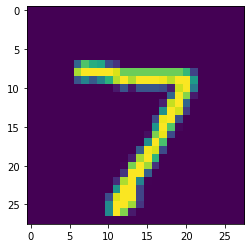

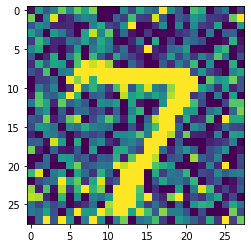

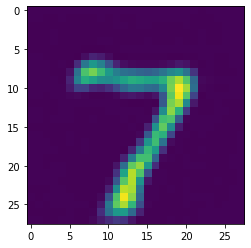

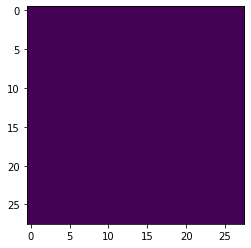

In [172]:
selected_model = 'small_snp_seed2568_seed_2568'
selected_epoch = 200
model = get_model(selected_model, selected_epoch, [1])
model = model.cuda()

for (clean, noisy, labels, this_noise_type) in val_generators['gaussian']:
    plt.imshow(clean[0][0])
    plt.figure()
    plt.imshow(noisy[0][0])
    clean, noisy = clean.cuda(), noisy.cuda()
    pred = model(noisy)
    mse = torch.abs(clean - pred) ** 2
    l1 = torch.abs(clean - pred)
    psnr = 10 * torch.log10(1. / (mse + 1e-16))
    print(mse[0].mean(), l1[0].mean(), psnr[0].mean())
    plt.figure()
    plt.imshow(pred[0][0].detach().cpu())
    model.module.convs[0].weight = torch.nn.parameter.Parameter(
        torch.zeros_like(model.module.convs[0].weight))
    model.module.convs[0].bias = torch.nn.parameter.Parameter(
        torch.zeros_like(model.module.convs[0].bias))
    pred = model(noisy)
    plt.figure()
    plt.imshow(pred[0][0].detach().cpu())
    break

In [193]:
# Get two solutions and interpolate in order to evaluate model on
def create_new_interpolated_model(new_model, model1, model2, alpha):
    for i, layer in enumerate(model1.module.convs):
        if hasattr(layer, 'weight'):
            new_model.module.convs[i].weight = torch.nn.parameter.Parameter(
                alpha * model2.module.convs[i].weight +
                (1. - alpha) * model1.module.convs[i].weight)
        if hasattr(layer, 'bias'):
            new_model.module.convs[i].bias = torch.nn.parameter.Parameter(
                alpha * model2.module.convs[i].bias +
                (1. - alpha) * model1.module.convs[i].bias)
    return new_model

def fetch_and_eval_interpolated_checkpoints_on_data(
    model_name_1 = 'small_snp_seed2568_seed_2568',
    model_name_2 = 'small_gau_seed2568_seed_2568',
    epoch_cnt_1 = 150, epoch_cnt_2 = 0, gpu_ids = [0], data_gen=None,
    interpolation_points=[]):
    
    model1 = get_model(model_name_1, epoch_cnt_1, gpu_ids)
    model2 = get_model(model_name_2, epoch_cnt_2, gpu_ids)
    new_model = get_model(model_name_1, epoch_cnt_1, gpu_ids)
    
    result_dic = {}
    for alpha in interpolation_points:
        new_model = create_new_interpolated_model(new_model, model1, model2, alpha)
        eval_df = run_model_on_data(new_model, data_gen)
        result_dic[alpha] = eval_df
    return result_dic



In [194]:
interpolation_points = np.arange(0., 1.01, 0.1)

result_dic = fetch_and_eval_interpolated_checkpoints_on_data(
    model_name_1 = 'small_snp_seed2568_seed_2568',
    model_name_2 = 'small_gau_seed2568_seed_2568',
    epoch_cnt_1 = 150, epoch_cnt_2 = 150, gpu_ids = [0], data_gen=val_generators['gaussian'],
    interpolation_points=interpolation_points)

Test: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


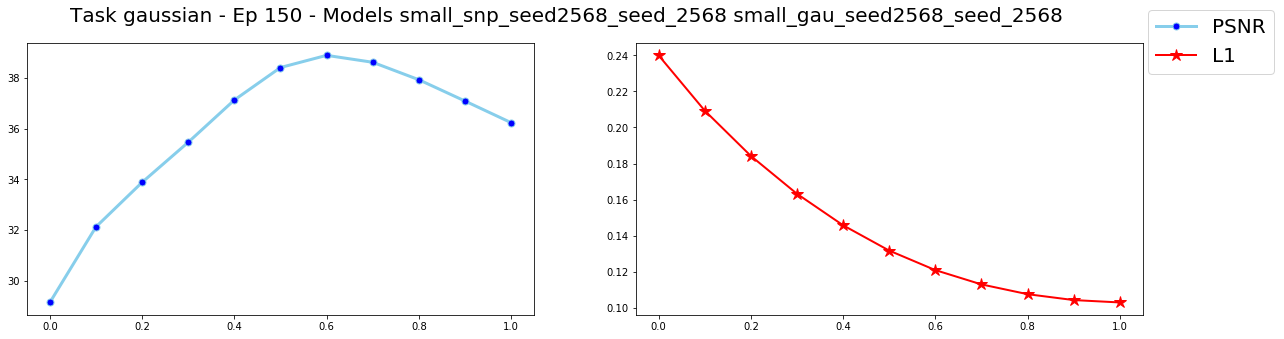

In [215]:
# Print the results for the gaussians
x = interpolation_points
task = 'gaussian'
epoch_cnt = 150
model_name_1 = 'small_snp_seed2568_seed_2568'
model_name_2 = 'small_gau_seed2568_seed_2568'

fontsize=20
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(x, [result_dic[i]['PSNR'].mean() for i in interpolation_points],
         marker='o', markerfacecolor='blue', markersize=7, color='skyblue', linewidth=3,
         linestyle='-', label='PSNR')
ax[1].plot(x, [result_dic[i]['L1'].mean() for i in interpolation_points],
         marker='*', markerfacecolor='red', markersize=12, color='red', linewidth=2,
         linestyle='-', label='L1')
plt.suptitle('Task {} - Ep {} - Models {} {}'.format(task, epoch_cnt, model_name_1, model_name_2),
             fontsize=fontsize)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines, labels, fontsize=fontsize, loc='upper right')

Test: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


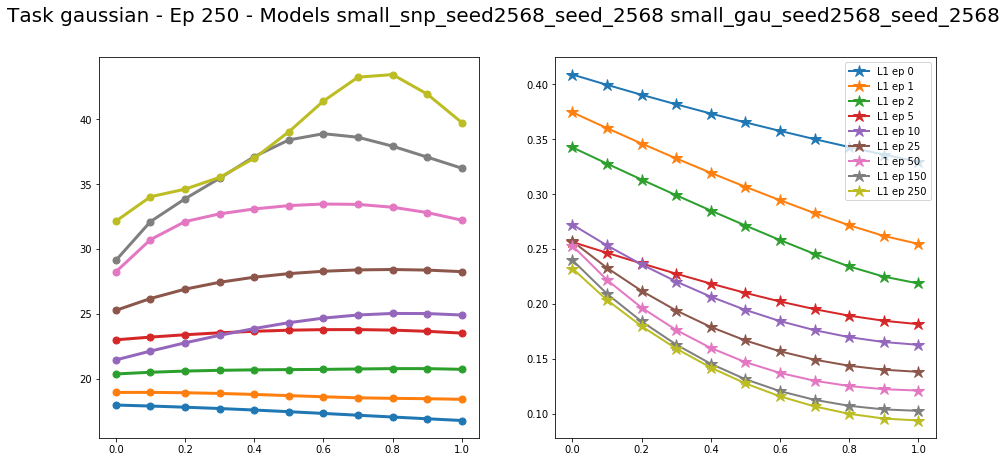

In [241]:
epochs_counts = [0, 1, 2, 5, 10, 25, 50, 150, 250]
interpolation_points = np.arange(0., 1.01, 0.1)
# epochs_counts = [0, 1]
# interpolation_points = np.arange(0., 1.01, 1)

fontsize=20
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
for epoch_cnt in epochs_counts:
    result_dic = fetch_and_eval_interpolated_checkpoints_on_data(
        model_name_1 = 'small_snp_seed2568_seed_2568',
        model_name_2 = 'small_gau_seed2568_seed_2568',
        epoch_cnt_1 = epoch_cnt, epoch_cnt_2 = epoch_cnt, gpu_ids = [0], data_gen=val_generators['gaussian'],
        interpolation_points=interpolation_points)

    x = interpolation_points
    task = 'gaussian'
    model_name_1 = 'small_snp_seed2568_seed_2568'
    model_name_2 = 'small_gau_seed2568_seed_2568'

    
    ax[0].plot(x, [result_dic[i]['PSNR'].mean() for i in interpolation_points],
             marker='o',
#                markerfacecolor='blue',
               markersize=7,
#                color='skyblue',
               linewidth=3,
             linestyle='-', label='PSNR ep {}'.format(epoch_cnt))
    ax[1].plot(x, [result_dic[i]['L1'].mean() for i in interpolation_points],
             marker='*',
#                markerfacecolor='red',
               markersize=12,
#                color='red',
               linewidth=2,
             linestyle='-', label='L1 ep {}'.format(epoch_cnt))
    
plt.suptitle('Task {} - Ep {} - Models {} {}'.format(task, epoch_cnt, model_name_1, model_name_2),
             fontsize=fontsize)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

# fig.legend(lines, labels, ncol=2, fontsize=fontsize,
# #            bbox_to_anchor=(0.45, 0.1),
#            loc='upper right')
# plt.tight_layout()
plt.legend()

 17%|█▋        | 1/6 [07:41<38:28, 461.69s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb6091fd0e0>
Traceback (most recent call last):
  File "/usr/local/anaconda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/anaconda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/anaconda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb6091fd0e0>
Traceback (most recent call last):
  File "/usr/local/anaconda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiPr

    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/anaconda/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb6091fd0e0>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/anaconda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/anaconda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/anaconda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb6091fd0e0

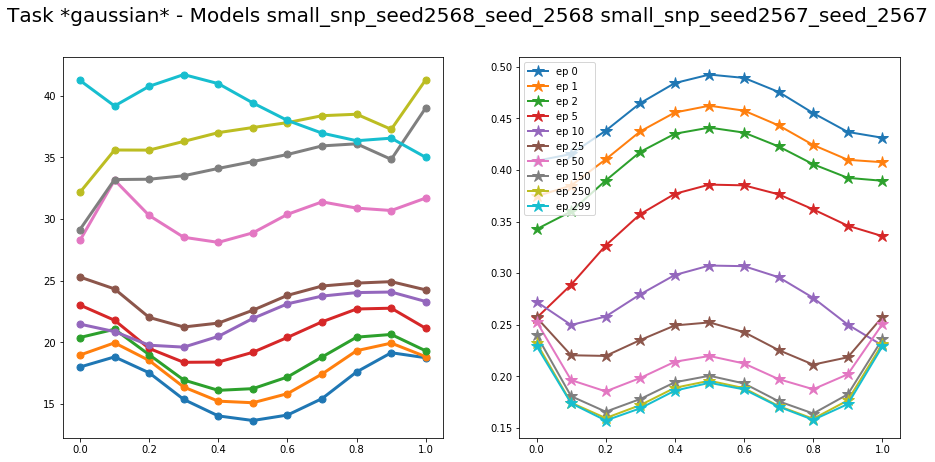

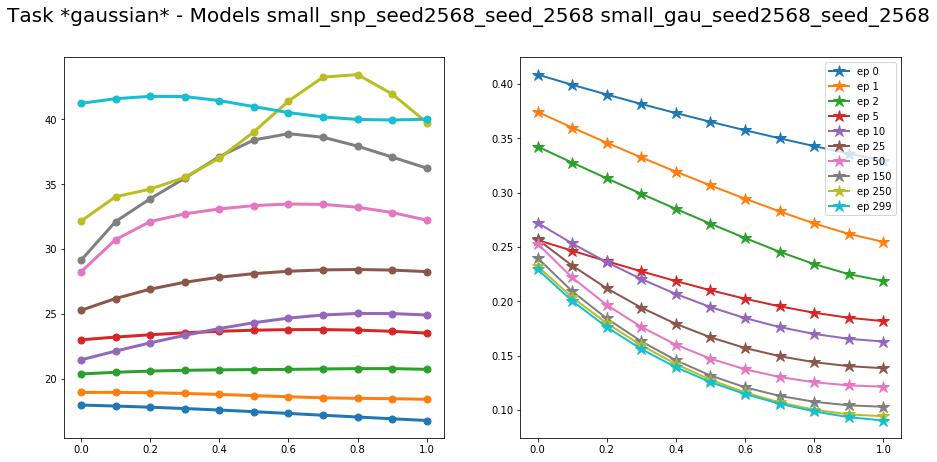

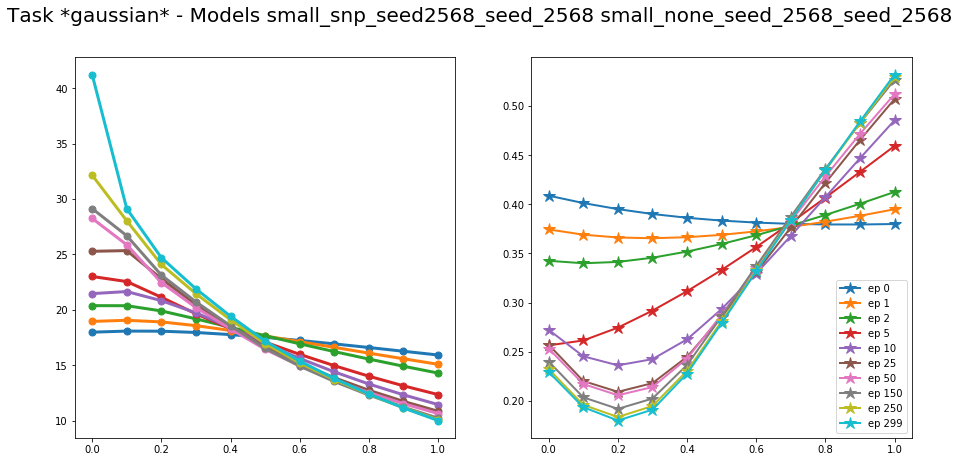

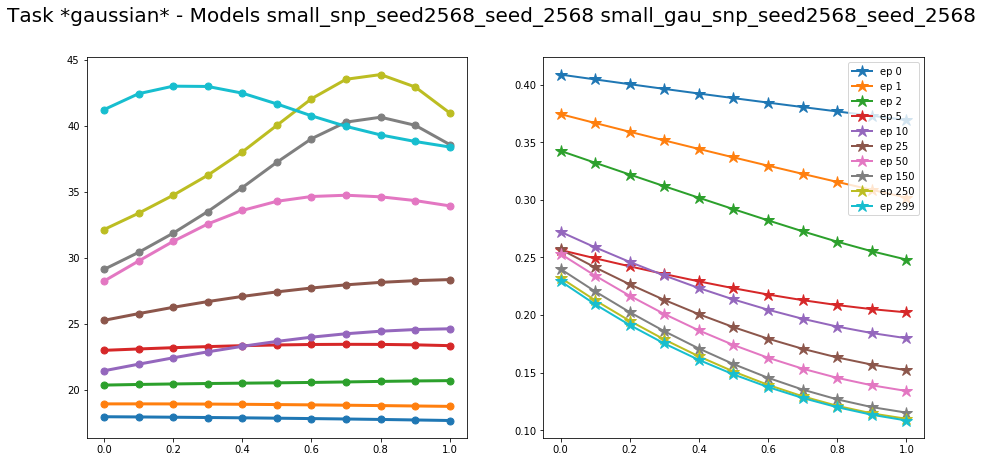

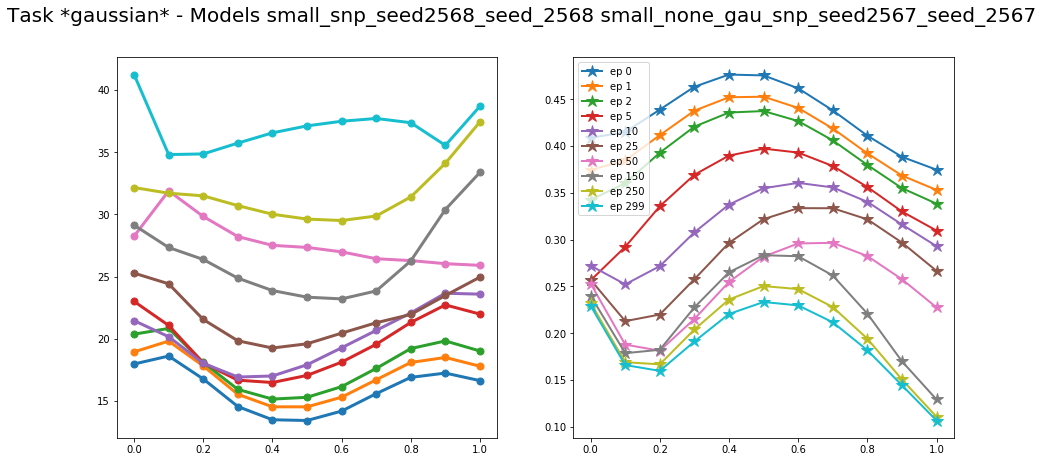

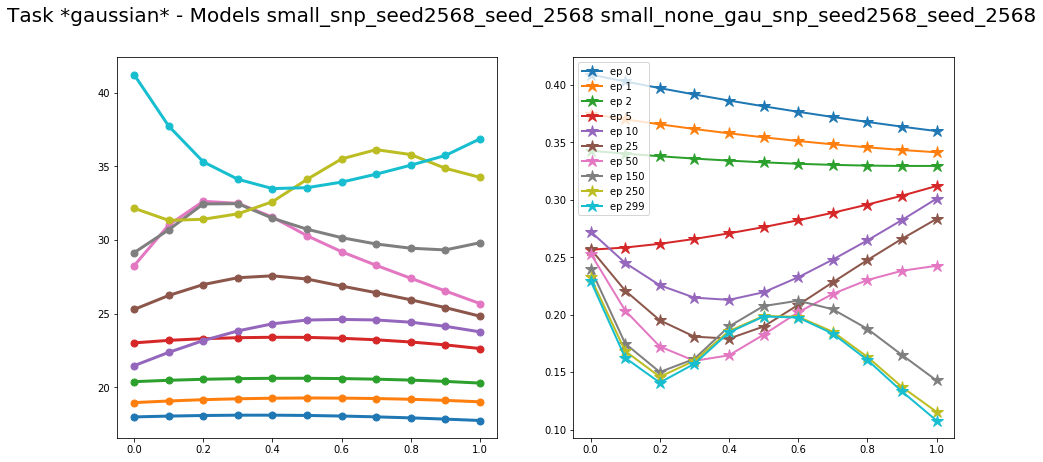

In [253]:
epochs_counts = [0, 1, 2, 5, 10, 25, 50, 150, 250, 299]
interpolation_points = np.arange(0., 1.01, 0.1)
# epochs_counts = [0, 1]
# interpolation_points = np.arange(0., 1.01, 1)
task = 'gaussian'

model_pairs = [
    ('small_snp_seed2568_seed_2568', 'small_snp_seed2567_seed_2567'),
    ('small_snp_seed2568_seed_2568', 'small_gau_seed2568_seed_2568'),
    ('small_snp_seed2568_seed_2568', 'small_none_seed_2568_seed_2568'),
    ('small_snp_seed2568_seed_2568', 'small_gau_snp_seed2568_seed_2568'),
    ('small_snp_seed2568_seed_2568', 'small_none_gau_snp_seed2567_seed_2567'),
    ('small_snp_seed2568_seed_2568', 'small_none_gau_snp_seed2568_seed_2568'),]

for models in tqdm(model_pairs):
    fontsize=20
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    for epoch_cnt in epochs_counts:
        result_dic = fetch_and_eval_interpolated_checkpoints_on_data(
            model_name_1 = models[0],
            model_name_2 = models[1],
            epoch_cnt_1 = epoch_cnt, epoch_cnt_2 = epoch_cnt, gpu_ids = [0], data_gen=val_generators['gaussian'],
            interpolation_points=interpolation_points)

        x = interpolation_points
        ax[0].plot(x, [result_dic[i]['PSNR'].mean() for i in interpolation_points],
                 marker='o',
                   markersize=7,
                   linewidth=3,
                 linestyle='-', label='ep {}'.format(epoch_cnt))
        ax[1].plot(x, [result_dic[i]['L1'].mean() for i in interpolation_points],
                 marker='*',
                   markersize=12,
                   linewidth=2,
                 linestyle='-', label='ep {}'.format(epoch_cnt))

    plt.suptitle('Task *{}* - Models {} {}'.format(task, models[0], models[1]),
                 fontsize=fontsize)

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    plt.legend()
#     plt.show()